*Identifying Nuts in Food Nerual Netowrk*

1.1 Dependencies

In [512]:
!pip3 install tensorflow opencv-python matplotlib

80850.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip3 install --upgrade pip


In [513]:
!pip3 list

80857.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Package                      Version
---------------------------- ---------
absl-py                      2.0.0
aiofiles                     23.2.1
aiohttp                      3.8.5
aiosignal                    1.3.1
anyio                        4.0.0
appdirs                      1.4.4
appnope                      0.1.3
astor                        0.8.1
asttokens                    2.4.0
astunparse                   1.6.3
async-timeout                4.0.3
attrs                        23.1.0
backcall                     0.2.0
blessed                      1.20.0
blinker                      1.6.3
Brotli                       1.1.0
browser-cookie3              0.19.1
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.16.0
charset-normalizer           3.2.0
click                        8.1.7
comm                         0.1.4
contourpy     

In [514]:
import tensorflow as tf
import os

In [515]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [516]:
len(gpus)

1

1.2 Remove Bad Images

In [599]:
import cv2
import imghdr

In [600]:
data_dir='data'

In [601]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [602]:
os.listdir(os.path.join(data_dir))

['.DS_Store', 'nuts', 'food']

In [604]:
for image_class in os.listdir('data'):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image)

chestnut169.JPG
almonds001.jpg
cashews131.jpg
braziliannuts115.jpg
peanut106.JPG
brazil129.JPG
hazelnut67.JPG
hazelnut73.JPG
pistachio135.JPG
braziliannuts101.jpg
peanut112.JPG
cashews125.jpg
hazelnut157.JPG
almonds015.jpg
chestnut155.JPG
pecans106.jpg
braziliannuts129.jpg
walnut35.JPG
brazil115.JPG
walnut21.JPG
pecans112.jpg
brazil101.JPG
chestnut141.JPG
almonds029.jpg
cashews119.jpg
hazelnut180.JPG
walnut148.JPG
hazelnuts028.jpg
hazelnut194.JPG
chestnut196.JPG
walnut174.JPG
hazelnut98.JPG
hazelnuts014.jpg
chestnut182.JPG
almond130.JPG
walnuts66.jpg
pecan15.JPG
walnuts72.jpg
almond124.JPG
pecan196.JPG
cashew16.JPG
cashew9.JPG
hazelnut3.JPG
almond118.JPG
pecan182.JPG
pecan29.JPG
almond27.JPG
pecan169.JPG
pistachios008.jpg
almond33.JPG
pine134.JPG
pecan155.JPG
pinenuts66.jpg
macadamia117.JPG
pecan141.JPG
pine120.JPG
pistachios034.jpg
pistachio27.JPG
peanut70.JPG
pistachio33.JPG
macedonia078.jpg
macedonia050.jpg
cashew134.JPG
pine17.JPG
peanut58.JPG
cashew120.JPG
macedonia044.jpg
macadam

In [605]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


1.3 Load Data

In [606]:
import numpy as np
from matplotlib import pyplot as plt

In [607]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 5470 files belonging to 2 classes.


In [608]:
data_iterator = data.as_numpy_iterator()

In [609]:
data_iterator

In [663]:
#get another batch from the iterator
batch = data_iterator.next()


In [611]:
len(batch) #two pipes to the pipline, images and labels

2

In [612]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [613]:
#class 1 = nuts
#class 0 = food
batch[1]

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1], dtype=int32)

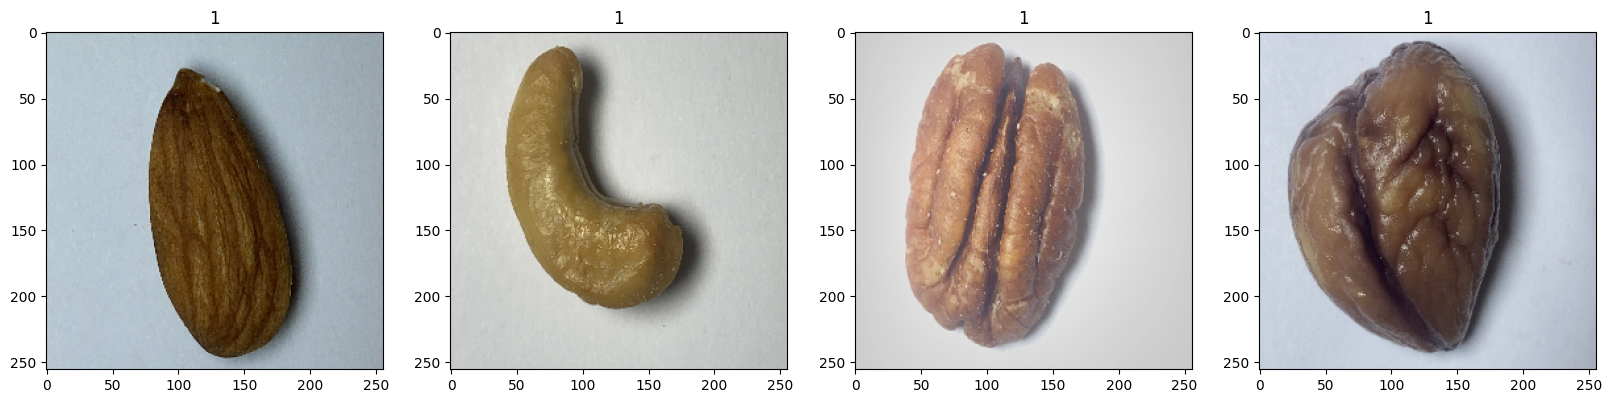

In [614]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [615]:
scaled = batch[0] / 255

In [616]:
scaled.max()

1.0

*Preprocess Data*

Scale Data

In [664]:
data = data.map(lambda x, y: (x/255, y))

In [618]:
scaled_iterator = data.as_numpy_iterator()

In [619]:
batch = scaled_iterator.next()

In [620]:
batch[0].min()

0.0

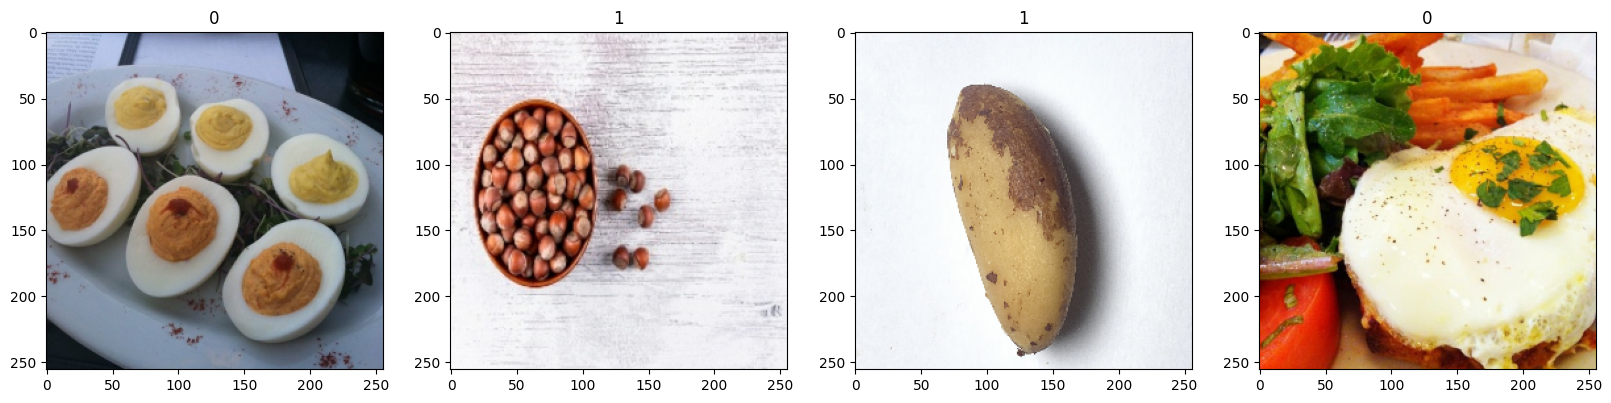

In [665]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Split Data

In [622]:
len(data)

171

In [623]:
train_size = int(len(data)*.7) #train the dataset
val_size = int(len(data)*.2) #finetune the model while trainign
test_size = int(len(data)*.1)+1 #test the model with new images (postraining)

In [624]:
train_size+val_size+test_size

171

In [625]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

*Deep Learning Model*

Deep Learning Network

In [626]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [627]:
model = Sequential()

In [628]:
#first layer is going to be a input convulution conv2d (16 filters 3by3 pixles in size, scaners over image and extract revelant information))
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [629]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [630]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

Train Model

In [631]:
logdir='logs'

In [632]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [633]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


 62/119 [==============>...............] - ETA: 18s - loss: 0.4534 - accuracy: 0.7979

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8196

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 73s 593ms/step - loss: 0.4047 - accuracy: 0.8196 - val_loss: 0.3086 - val_accuracy: 0.8529
Epoch 2/20
 62/119 [==============>...............] - ETA: 19s - loss: 0.2400 - accuracy: 0.9007

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9091

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 74s 607ms/step - loss: 0.2300 - accuracy: 0.9091 - val_loss: 0.1770 - val_accuracy: 0.9403
Epoch 3/20
 62/119 [==============>...............] - ETA: 19s - loss: 0.1254 - accuracy: 0.9546

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9548

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 76s 622ms/step - loss: 0.1254 - accuracy: 0.9548 - val_loss: 0.1611 - val_accuracy: 0.9504
Epoch 4/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0829 - accuracy: 0.9733

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9666

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 75s 616ms/step - loss: 0.0945 - accuracy: 0.9666 - val_loss: 0.2105 - val_accuracy: 0.9182
Epoch 5/20
 61/119 [==============>...............] - ETA: 21s - loss: 0.0758 - accuracy: 0.9688

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9685

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 77s 630ms/step - loss: 0.0808 - accuracy: 0.9685 - val_loss: 0.1119 - val_accuracy: 0.9559
Epoch 6/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0483 - accuracy: 0.9839

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9803

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 76s 624ms/step - loss: 0.0544 - accuracy: 0.9803 - val_loss: 0.1499 - val_accuracy: 0.9421
Epoch 7/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0472 - accuracy: 0.9819

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9845

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 76s 623ms/step - loss: 0.0440 - accuracy: 0.9845 - val_loss: 0.1577 - val_accuracy: 0.9467
Epoch 8/20
 61/119 [==============>...............] - ETA: 20s - loss: 0.0339 - accuracy: 0.9877

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9887

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 77s 634ms/step - loss: 0.0323 - accuracy: 0.9887 - val_loss: 0.1332 - val_accuracy: 0.9531
Epoch 9/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0389 - accuracy: 0.9859

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9905

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 76s 629ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.1216 - val_accuracy: 0.9651
Epoch 10/20
 61/119 [==============>...............] - ETA: 20s - loss: 0.0114 - accuracy: 0.9959

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9976

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 79s 652ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 0.1251 - val_accuracy: 0.9669
Epoch 11/20
 62/119 [==============>...............] - ETA: 21s - loss: 0.0363 - accuracy: 0.9884

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9866

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 78s 646ms/step - loss: 0.0387 - accuracy: 0.9866 - val_loss: 0.2020 - val_accuracy: 0.9403
Epoch 12/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0257 - accuracy: 0.9894

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9929

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 78s 642ms/step - loss: 0.0185 - accuracy: 0.9929 - val_loss: 0.0855 - val_accuracy: 0.9688
Epoch 13/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0066 - accuracy: 0.9970

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9963

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 78s 645ms/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 0.1603 - val_accuracy: 0.9531
Epoch 14/20
 62/119 [==============>...............] - ETA: 20s - loss: 0.0147 - accuracy: 0.9945

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9966

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 78s 646ms/step - loss: 0.0103 - accuracy: 0.9966 - val_loss: 0.1267 - val_accuracy: 0.9660
Epoch 15/20
 61/119 [==============>...............] - ETA: 21s - loss: 0.0015 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 80s 657ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9642
Epoch 16/20
 62/119 [==============>...............] - ETA: 20s - loss: 4.3149e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 8.1463e-04 - accuracy: 0.9997

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 78s 645ms/step - loss: 8.1463e-04 - accuracy: 0.9997 - val_loss: 0.1425 - val_accuracy: 0.9669
Epoch 17/20
 62/119 [==============>...............] - ETA: 21s - loss: 0.0015 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 9.9207e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 79s 650ms/step - loss: 9.9207e-04 - accuracy: 1.0000 - val_loss: 0.1436 - val_accuracy: 0.9706
Epoch 18/20
 62/119 [==============>...............] - ETA: 20s - loss: 2.4105e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 2.4950e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 80s 657ms/step - loss: 2.4950e-04 - accuracy: 1.0000 - val_loss: 0.1575 - val_accuracy: 0.9688
Epoch 19/20
 62/119 [==============>...............] - ETA: 21s - loss: 1.5209e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 1.7563e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 81s 663ms/step - loss: 1.7563e-04 - accuracy: 1.0000 - val_loss: 0.1725 - val_accuracy: 0.9669
Epoch 20/20
 62/119 [==============>...............] - ETA: 21s - loss: 1.3124e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - ETA: 0s - loss: 1.3314e-04 - accuracy: 1.0000

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


119/119 [==============================] - 81s 670ms/step - loss: 1.3314e-04 - accuracy: 1.0000 - val_loss: 0.1491 - val_accuracy: 0.9688


In [634]:
hist.history

{'loss': [0.4046951234340668,
  0.22995060682296753,
  0.125383198261261,
  0.09450644254684448,
  0.08083091676235199,
  0.05437592417001724,
  0.04398595914244652,
  0.032313887029886246,
  0.027784215286374092,
  0.009519336745142937,
  0.03868755325675011,
  0.018538624048233032,
  0.010436282493174076,
  0.01033798512071371,
  0.0012809698237106204,
  0.0008146340842358768,
  0.0009920726297423244,
  0.000249499425990507,
  0.00017562753055244684,
  0.00013313547242432833],
 'accuracy': [0.8195903301239014,
  0.9091386795043945,
  0.9548319578170776,
  0.9666491746902466,
  0.9684873819351196,
  0.9803045988082886,
  0.9845063090324402,
  0.988707959651947,
  0.9905462265014648,
  0.9976365566253662,
  0.9866071343421936,
  0.9929096698760986,
  0.9963235259056091,
  0.9965861439704895,
  1.0,
  0.9997373819351196,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.3086091876029968,
  0.17698132991790771,
  0.16105520725250244,
  0.21049463748931885,
  0.11186083406209946,
  0.149920314

Plot Performance

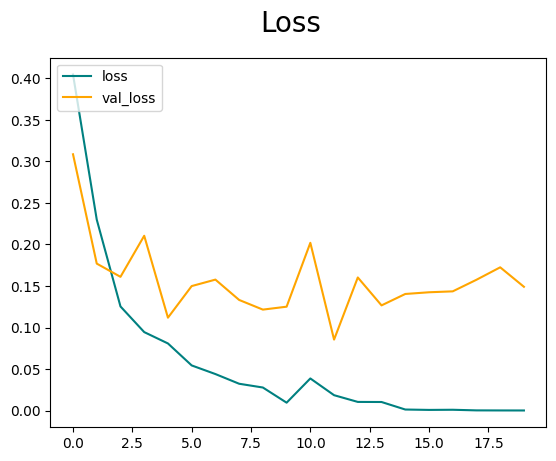

In [635]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

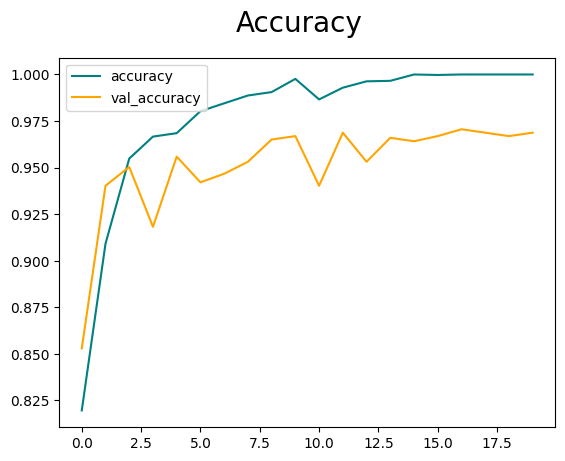

In [636]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Evaluate Performance**

Evaluate Model

In [637]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [638]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [639]:
len(test)

18

In [640]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

Corrupt JPEG data: 6722 extraneous bytes before marker 0xd0


1/1 [==============================] - 0s 94ms/step


In [641]:


print(pre.result(), re.result(), acc.result())



tf.Tensor(0.96245736, shape=(), dtype=float32) tf.Tensor(0.94949496, shape=(), dtype=float32) tf.Tensor(0.9547038, shape=(), dtype=float32)


In [642]:
print(F'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()},Accuracy: {acc.result()}')

Precision: 0.9624573588371277, Recall: 0.9494949579238892,Accuracy: 0.9547038078308105


Test

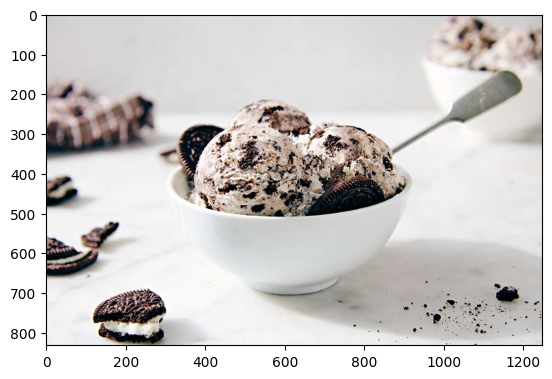

In [706]:
img = cv2.imread('icecream.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

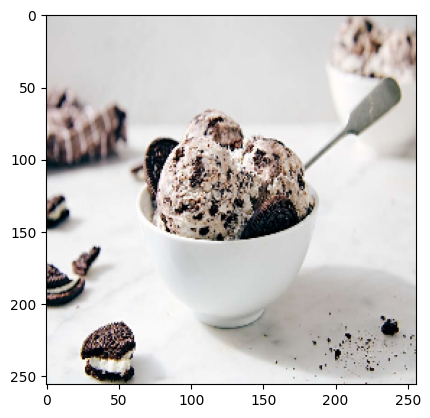

In [707]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize the image using TensorFlow
resize = tf.image.resize(img_rgb, (256, 256))

# Convert the resized image back to NumPy array
resize = resize.numpy().astype(int)

# Display the resized image
plt.imshow(resize)
plt.show()

In [708]:
yhat = model.predict(np.expand_dims(resize/255, 0))
#formatted_yhat = "{:.10f}".format(yhat[0, 0])

1/1 [==============================] - 0s 36ms/step


In [709]:
yhat

array([[1.6288762e-11]], dtype=float32)

In [710]:
if yhat > 0.5: 
    print(f'Predicted food has nuts')
else:
    print(f'Predicted food does not have nuts')

Predicted food does not have nuts


**Save the Model**

Save

In [711]:
from tensorflow.keras.models import load_model

In [712]:
model.save(os.path.join('models','foodnutidentifier.h5'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [714]:
new_model = load_model(os.path.join('models','foodnutidentifier.h5'))

In [715]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 47ms/step


In [718]:
if yhatnew > 0.5: 
    print(f'Predicted food has nuts')
else:
    print(f'Predicted food does not have nuts')

Predicted food does not have nuts
